# 卷积神经网络的可视化

### Step 1：可视化中间激活

In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [2]:
# 预处理单张图像
img_path = 'D:/ML/cats_and_dogs_small/test/cats/cat.1700.jpg'

import numpy as np
from keras.utils import image_utils

img = image_utils.load_img(img_path, target_size=(150, 150))
img_tensor = image_utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255. 

print(img_tensor.shape)

(1, 150, 150, 3)


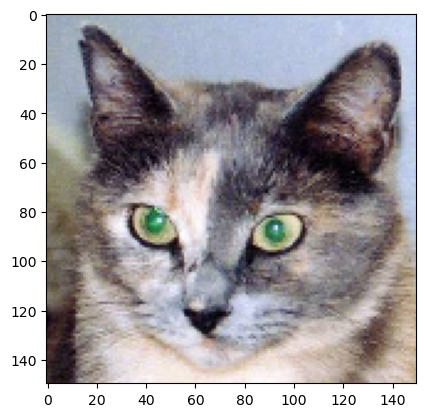

In [3]:
# 显示测试图像
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [6]:
# 用一个输入张量和一个输出张量列表将模型实例化
from keras import models 

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# 以预测模式运行模型
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
first_layer_activation.shape

1/1 [==============================] - 0s 211ms/step


(1, 148, 148, 32)

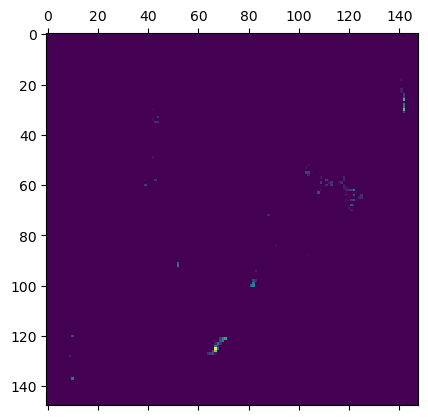

In [7]:
# 将第四个通道可视化
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

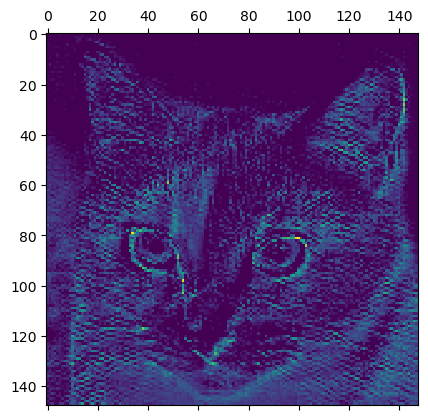

In [9]:
# 将第7个通道可视化
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

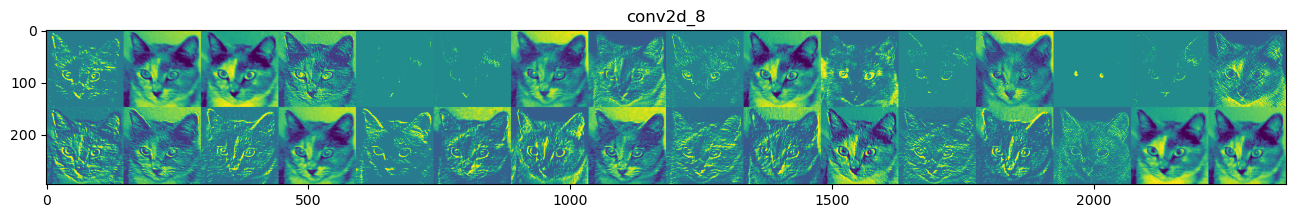

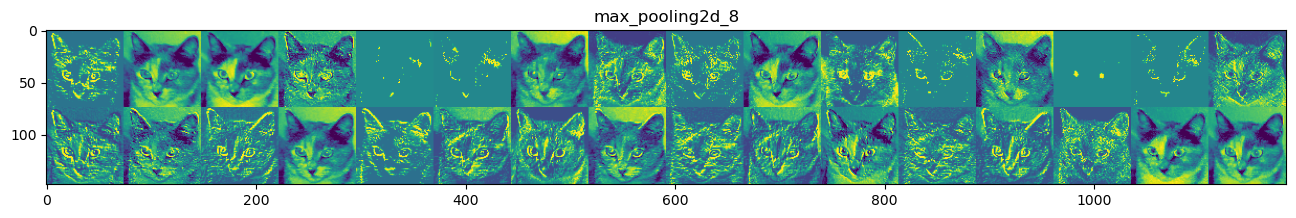

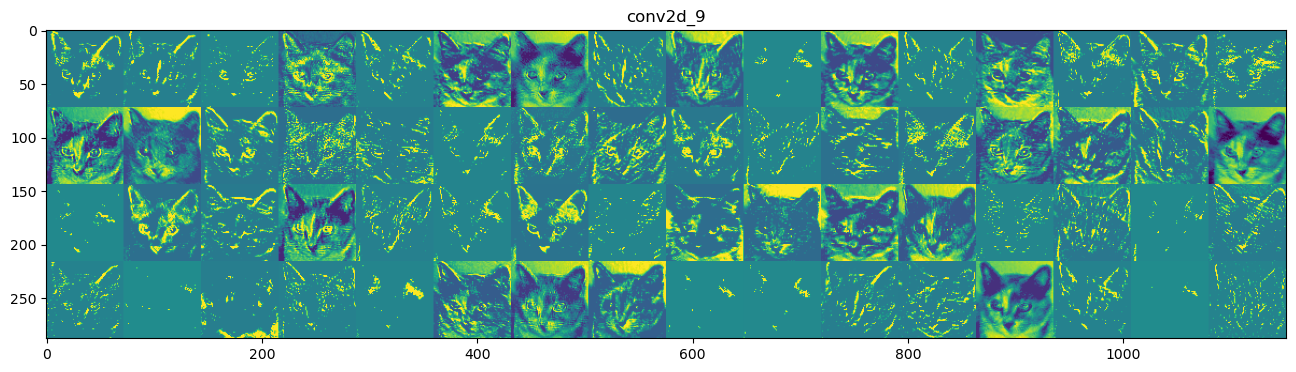

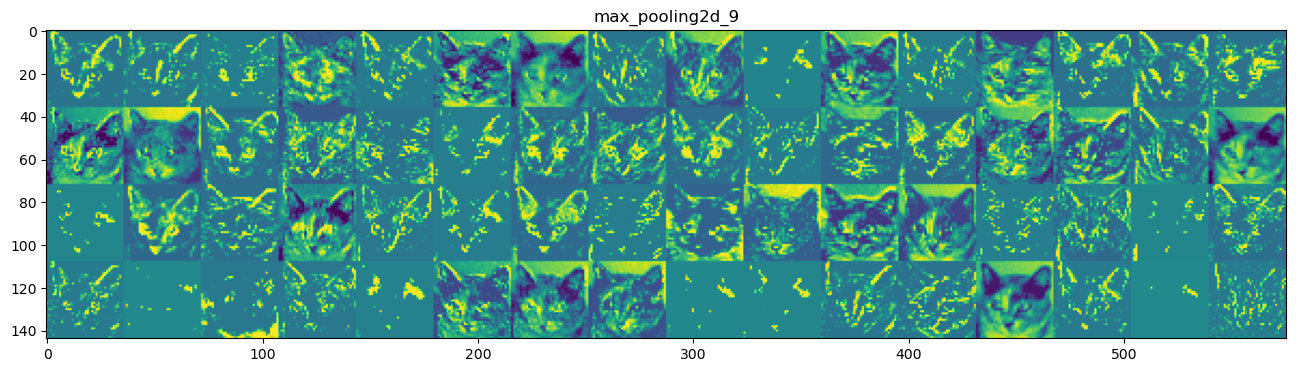

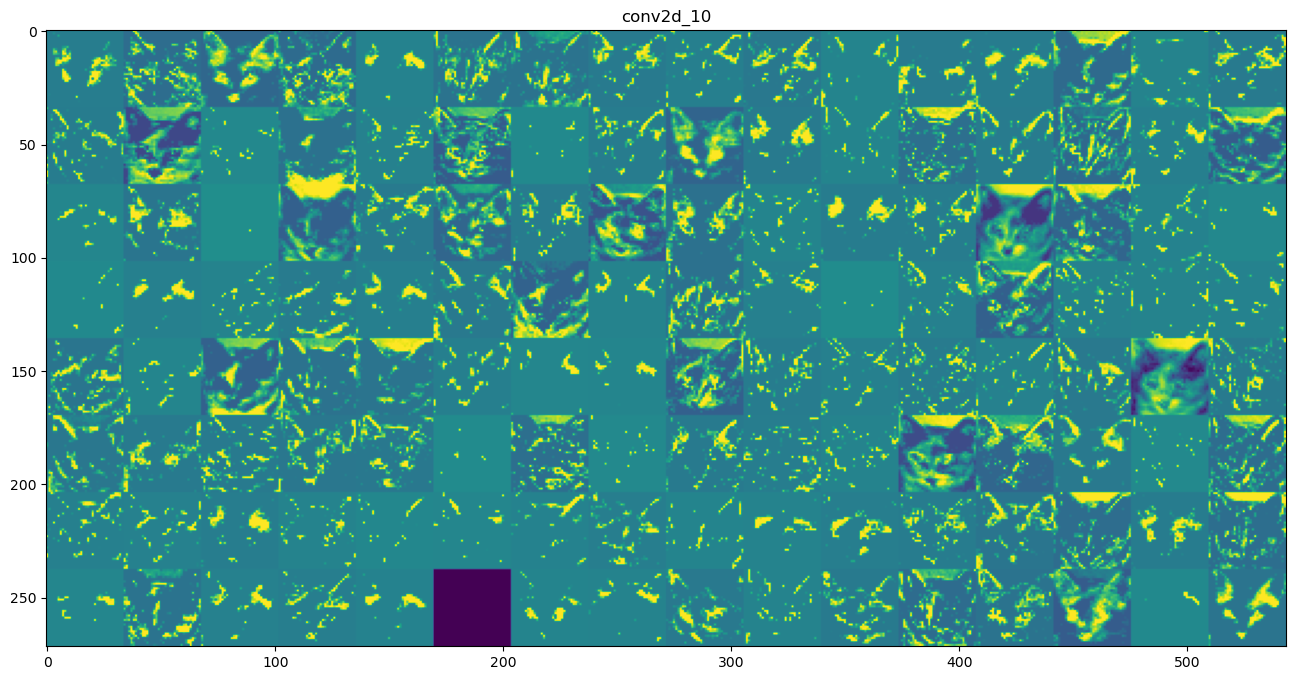

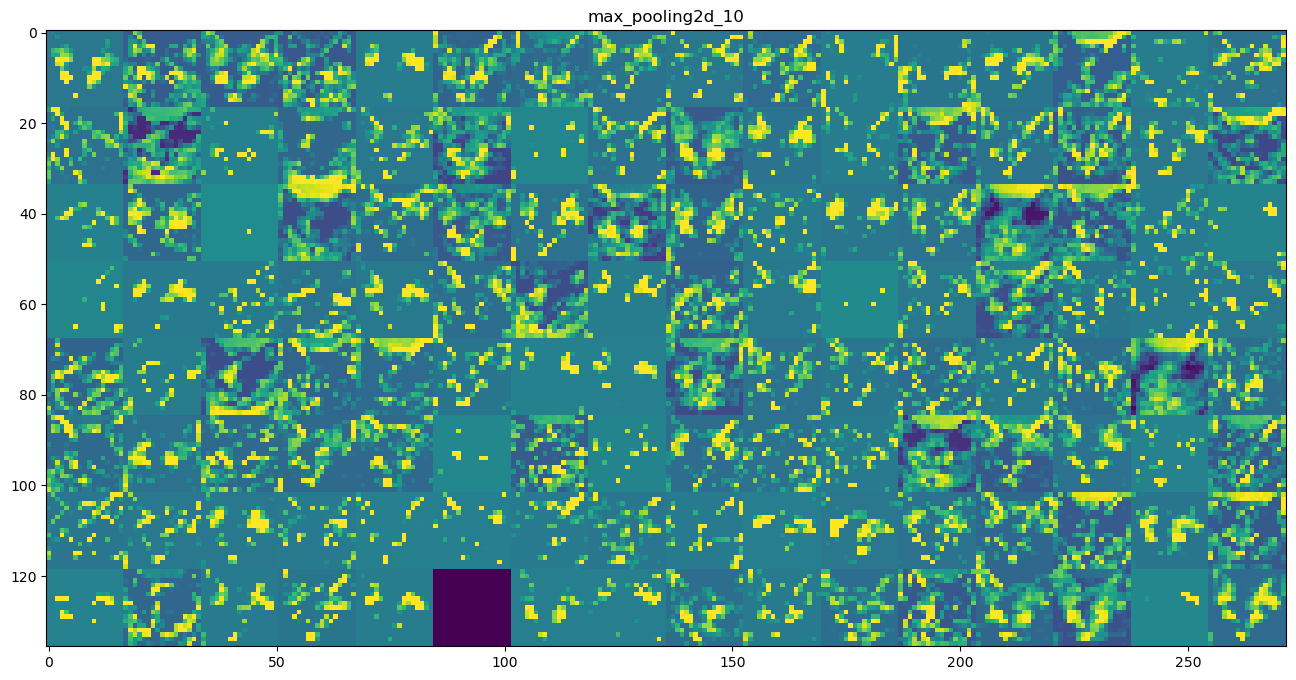

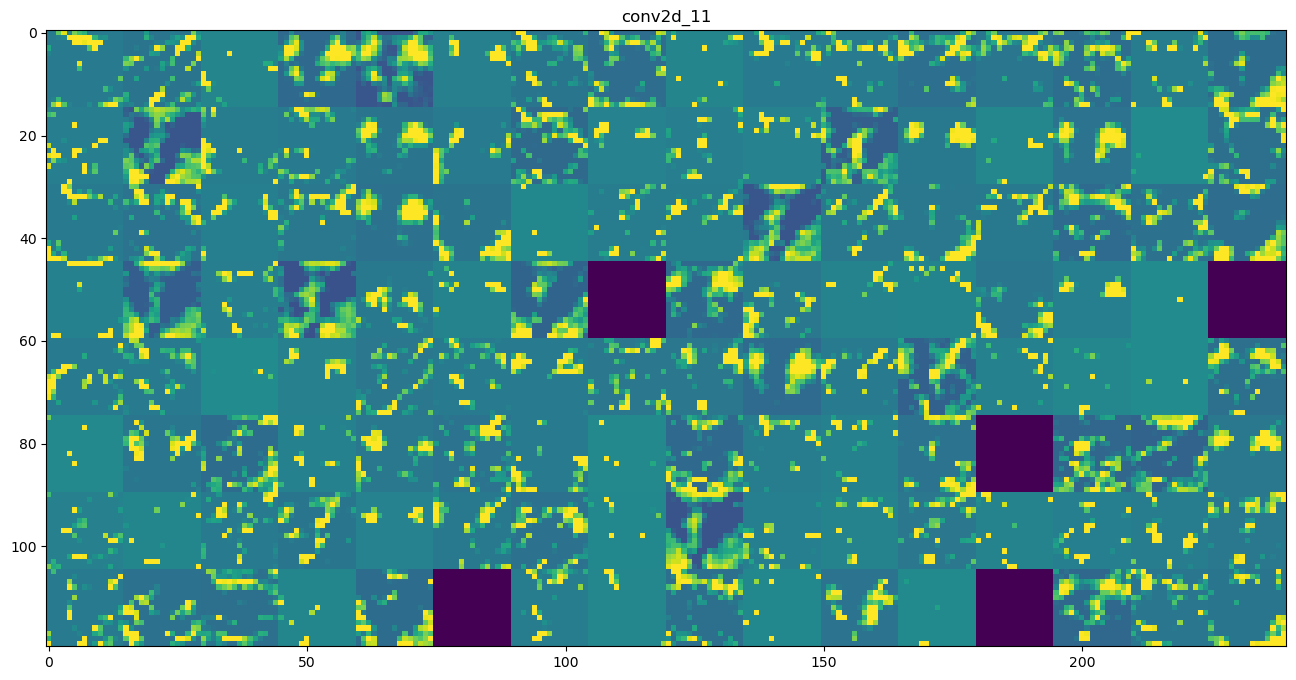

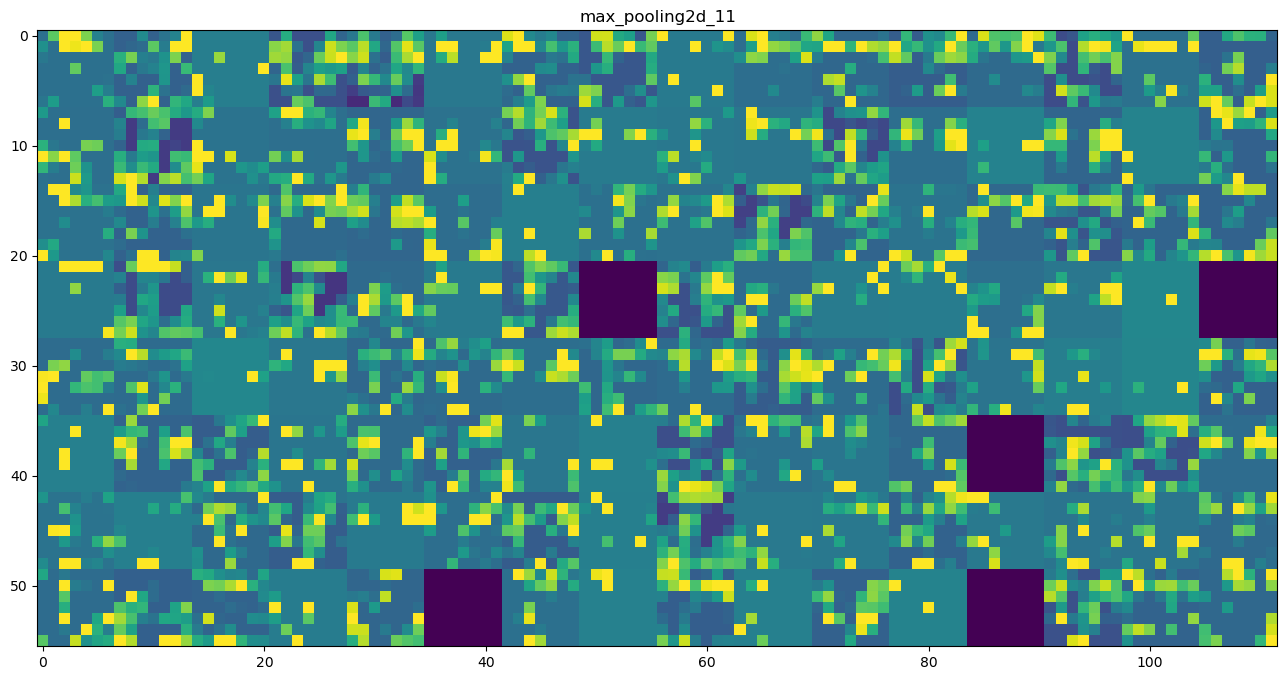

In [17]:
# 将每个中间激活的所有通道可视化
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

image_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] # 特征图中的特征个数
    
    size = layer_activation.shape[1] #特征图的形状为 (1, size, size, n_features
    
    n_cols = n_features // image_per_row
    display_grid = np.zeros((size * n_cols, image_per_row * size))
    
    for col in range(n_cols):
        for row in range(image_per_row):
            channel_image = layer_activation[0,
                                             :, :, 
                                             col * image_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
        
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Step 3：可视化类激活的热力图

In [1]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights ='imagenet')

from keras.utils import image_utils
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'D:/ML/creative_common_elephant.jpg'

img = image_utils.load_img(img_path, target_size=(224, 224))

x = image_utils.img_to_array(img)

x = np.expand_dims(x, axis=0)

# 对批量进行预处理（按通道进行颜色标准化）
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted: ', decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 5us/step
Predicted:  [('n02504458', 'African_elephant', 0.80498177), ('n01871265', 'tusker', 0.17711288), ('n02504013', 'Indian_elephant', 0.01759062)]


In [2]:
 np.argmax(preds[0])

386

In [12]:
from keras import backend as K
import tensorflow as tf

african_elephant_output = model.output[:, 386]  

last_conv_layer = model.get_layer('block5_conv3') 

with tf.GradientTape() as gtape:
    grads = gtape.gradient(african_elephant_output, last_conv_layer.output)

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]]) 

pooled_grads_value, conv_layer_output_value = iterate([x]) 

for i in range(512): 
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1) 

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

AttributeError: 'KerasTensor' object has no attribute '_id'